In [14]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from datetime import datetime

Converting csv data to database file

In [4]:
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

In [5]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:00:05.051569


In [6]:
con = sqlite3.connect('train.db')
df = pd.read_sql_query('SELECT * FROM data',con)
con.close()
print(df)

             index       Id  \
0                1       Id   
1                2        1   
2                3        2   
3                4        3   
4                5        4   
...            ...      ...   
6034191  107014192  6034191   
6034192  107014193  6034192   
6034193  107014194  6034193   
6034194  107014195  6034194   
6034195  107014196  6034195   

                                                     Title  \
0                                                    Title   
1        How to check if an uploaded file is an image w...   
2        How can I prevent firefox from closing when I ...   
3                 R Error Invalid type (list) for variable   
4            How do I replace special characters in a URL?   
...                                                    ...   
6034191                        Parse JSON or XML in Status   
6034192              Javascript resize on every image load   
6034193                       Update database with big CSV   
6034194

In [7]:
if os.path.isfile('train.db'):
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()

In [8]:
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [9]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 1827881 ( 30.292038906260256 % )


In [10]:
# adding a new feature number of tags per question
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(str(text).split(" ")))
df_no_dup.head()

,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


Number of times each question appeared in our database

In [11]:
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [12]:
df_no_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568298
5     505158
Name: tag_count, dtype: int64

Creating a new database with no duplicates

In [13]:
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [14]:
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    con.close()

In [15]:
tag_data

,Tags
0,c++ c
1,c# silverlight data-binding
2,c# silverlight data-binding columns
3,jsp jstl
4,java jdbc
...,...
4206310,wordpress wordpress-plugin
4206311,php mysql text
4206312,php codeigniter character-encoding
4206313,php email outlook mime


In [18]:
tag_data["Tags"] = tag_data["Tags"].apply(lambda text : str(text))

In [19]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [20]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206315
Number of unique tags : 42049


<h2>Cleaning and Preprocessing</h2>

<ol> 
    <li> Sample 1M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Special characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [21]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [19]:
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e) 
    return None

def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

In [23]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


# Sampling 1 Million Questions

In [24]:
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


In [27]:
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
number of questions completed= 600000
number of questions completed= 700000
number of questions completed= 800000
number of questions completed= 900000
Avg. length of questions(Title+Body) before processing: 1169
Avg. length of questions(Title+Body) after processing: 326
Percent of questions containing code: 57
Time taken to run this cell : 0:30:59.220067


In [28]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [29]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('shutdown hook execut applic launch use javaw exe use javaw exe launch java applic shutdown hook execut user log window account applic actual launch use launch generat exe file know use javaw exe start seem known bug http bug sun com bugdatabas view bug bug id anyon els problem fix thank',)
----------------------------------------------------------------------------------------------------
('fragment size ext filesystem output dump fs relat disk fragment',)
----------------------------------------------------------------------------------------------------
('boost thread pass scope lock calle new boost thread librari situat acquir scope lock one function need wait calle code line basic function need access scope lock acquir wait thread notifi direct wait mutex instead lock help appreici thank',)
----------------------------------------------------------------------------------------------------
('bash cron redirect restor stdout stderr produc permiss deni 

### Taking 1 Million entries to a dataframe.

In [21]:
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [22]:
preprocessed_data.head()

,question,tags
0,use find packag includ network librari cpp net...,boost cmake shared-libraries cpp-netlib
1,shutdown hook execut applic launch use javaw e...,java windows
2,fragment size ext filesystem output dump fs re...,filesystems ext3
3,boost thread pass scope lock calle new boost t...,c++ boost boost-thread boost-mutex scoped-lock
4,bash cron redirect restor stdout stderr produc...,bash cron stdout stderr


In [23]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 999997
number of dimensions : 2


# Machine Learning Model

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

## Converting into a Binary Vector

In [ ]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

# Sampling tags

In [25]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [26]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

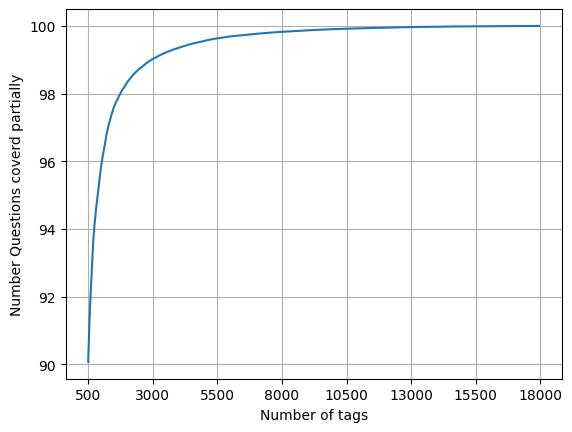

with  5500 tags we are covering  99.018 % of questions


In [27]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [28]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 9818 out of  999997


In [29]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 35410
number of tags taken : 5500 ( 15.532335498446766 %)


# Train -Test Split


In [30]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [31]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (799997, 5500)
Number of data points in test data : (200000, 5500)


# Featurizing Data

In [32]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:04:28.797201


In [33]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (799997, 87991) Y : (799997, 5500)
Dimensions of test data X: (200000, 87991) Y: (200000, 5500)


In [59]:
import pickle

Logistic Regression

In [61]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, loss='log',
                                            penalty='l1'),
                    n_jobs=-1)

In [67]:
pickle.dump(classifier, open('model.pkl', 'wb'))

In [68]:
classifier = pickle.load(open('model.pkl', 'rb'))

In [66]:
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.081175
macro f1 score : 0.09749584048788025
micro f1 scoore : 0.3751075684024714
hamming loss : 0.0004119290909090909
Precision recall report :
               precision    recall  f1-score   support

           0       0.62      0.23      0.34     15612
           1       0.78      0.43      0.56     14326
           2       0.82      0.54      0.65     13333
           3       0.75      0.43      0.54     12740
           4       0.94      0.76      0.84     11194
           5       0.85      0.65      0.74     10508
           6       0.71      0.31      0.43      6784
           7       0.86      0.59      0.70      6400
           8       0.72      0.38      0.50      6283
           9       0.78      0.41      0.54      5787
          10       0.85      0.61      0.71      5884
          11       0.54      0.18      0.27      5661
          12       0.51      0.09      0.15      5304
          13       0.60      0.24      0.34      4867
          14       0.63      0.